# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [4]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [5]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [6]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [7]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    trans = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    
    image_folder = datasets.ImageFolder(data_dir, transform=trans)
    data_loader = torch.utils.data.DataLoader(dataset=image_folder, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [8]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

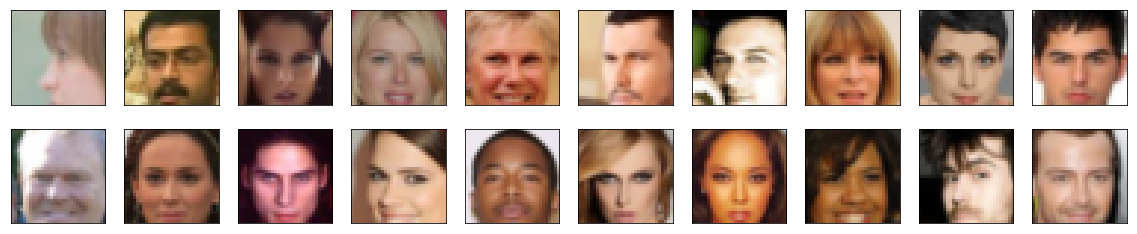

In [9]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [10]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x * (feature_range[1] - feature_range[0]) + feature_range[0]
    
    return x


In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.4431)
Max:  tensor(0.8275)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# inspired from the one used in the DCGAN notebook
def new_conv(in_ch, out_ch, norm=True):
    # hardcoded values for stride and kernel size since I know 
    # I will use those ones.
    layers = [nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False),]
    if norm:
        layers.append(nn.BatchNorm2d(out_ch))
    
    return nn.Sequential(*layers)
    
    

In [14]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv1 = new_conv(3, conv_dim, norm=False)
        self.conv2 = new_conv(conv_dim, conv_dim*2)
        self.conv3 = new_conv(conv_dim*2, conv_dim*4)
        self.conv4 = new_conv(conv_dim*4, conv_dim*8)
        
        self.fc = nn.Linear(2*2*conv_dim*8, 1)
        
        self.drop = nn.Dropout(0.2)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        batch_size = x.shape[0]
        x = F.leaky_relu(self.conv1(x))
        x = self.drop(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.drop(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.drop(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.drop(x)
        
        x = x.reshape(batch_size, -1)
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [15]:
# inspired from the one used in the DCGAN notebook
def new_deconv(in_ch, out_ch, norm=True):
    # hardcoded values for stride and kernel size since I know 
    # I will use those ones.
    layers = [nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False),]
    if norm:
        layers.append(nn.BatchNorm2d(out_ch))
    
    return nn.Sequential(*layers)

In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.fc = nn.Linear(z_size, 2*2 * conv_dim*8)
        
        self.conv_t1 = new_deconv(conv_dim*8, conv_dim*4)
        self.conv_t2 = new_deconv(conv_dim*4, conv_dim*2)
        self.conv_t3 = new_deconv(conv_dim*2, conv_dim)
        self.conv_t4 = new_deconv(conv_dim, 3)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        batch_size = x.shape[0]
        x = self.fc(x)
        x = x.reshape(batch_size, -1, 2, 2)
        
        x = F.relu(self.conv_t1(x))
        x = F.relu(self.conv_t2(x))
        x = F.relu(self.conv_t3(x))
        x = F.tanh(self.conv_t4(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [17]:

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0, 0.02)
        
        
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [19]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (drop): Dropout(p=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (conv_t1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), pa

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [21]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    criterion = nn.BCEWithLogitsLoss()
    labels = torch.ones(D_out.shape[0])
    if train_on_gpu:
        labels = labels.cuda()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    criterion = nn.BCEWithLogitsLoss()
    labels = torch.zeros(D_out.shape[0])
    if train_on_gpu:
        labels = labels.cuda()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [22]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [23]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()
            

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda() 
            fake_images = G(z)
            
            
            d_fake = D(fake_images)
            d_real = D(real_images)
            
            d_loss = real_loss(d_real) + fake_loss(d_fake)
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda() 
            fake_images = G(z)
            d_fake = D(fake_images)
            
            g_loss = real_loss(d_fake)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [24]:
from workspace_utils import active_session

# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4490 | g_loss: 0.7275
Epoch [    1/   50] | d_loss: 0.2233 | g_loss: 3.2612
Epoch [    1/   50] | d_loss: 0.0913 | g_loss: 4.4238
Epoch [    1/   50] | d_loss: 0.0346 | g_loss: 4.9999
Epoch [    1/   50] | d_loss: 0.0193 | g_loss: 5.6795
Epoch [    1/   50] | d_loss: 0.0043 | g_loss: 6.3665
Epoch [    1/   50] | d_loss: 0.0161 | g_loss: 5.2290
Epoch [    1/   50] | d_loss: 0.0108 | g_loss: 5.6598
Epoch [    1/   50] | d_loss: 0.0057 | g_loss: 6.0751
Epoch [    1/   50] | d_loss: 0.0059 | g_loss: 6.7257
Epoch [    1/   50] | d_loss: 0.0223 | g_loss: 5.5763
Epoch [    1/   50] | d_loss: 0.2130 | g_loss: 2.9474
Epoch [    1/   50] | d_loss: 0.1087 | g_loss: 3.9859
Epoch [    1/   50] | d_loss: 0.1640 | g_loss: 4.0623
Epoch [    1/   50] | d_loss: 0.0698 | g_loss: 3.7569
Epoch [    1/   50] | d_loss: 0.3263 | g_loss: 2.5611
Epoch [    1/   50] | d_loss: 0.4465 | g_loss: 2.6696
Epoch [    1/   50] | d_loss: 0.3559 | g_loss: 4.3938
Epoch [    1/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.5687 | g_loss: 2.9734
Epoch [    6/   50] | d_loss: 0.6419 | g_loss: 1.5250
Epoch [    6/   50] | d_loss: 0.6627 | g_loss: 2.8144
Epoch [    6/   50] | d_loss: 1.2124 | g_loss: 0.5725
Epoch [    6/   50] | d_loss: 0.4850 | g_loss: 3.2571
Epoch [    6/   50] | d_loss: 0.6389 | g_loss: 2.5012
Epoch [    6/   50] | d_loss: 0.4073 | g_loss: 1.9004
Epoch [    6/   50] | d_loss: 0.7336 | g_loss: 2.0259
Epoch [    6/   50] | d_loss: 0.6932 | g_loss: 2.5805
Epoch [    6/   50] | d_loss: 0.4233 | g_loss: 3.5247
Epoch [    6/   50] | d_loss: 0.6301 | g_loss: 2.4658
Epoch [    6/   50] | d_loss: 0.5350 | g_loss: 3.0508
Epoch [    6/   50] | d_loss: 0.7485 | g_loss: 1.1595
Epoch [    6/   50] | d_loss: 0.5060 | g_loss: 2.0679
Epoch [    6/   50] | d_loss: 0.6608 | g_loss: 2.8196
Epoch [    6/   50] | d_loss: 1.1695 | g_loss: 1.8636
Epoch [    6/   50] | d_loss: 0.4287 | g_loss: 2.0731
Epoch [    6/   50] | d_loss: 0.4724 | g_loss: 1.9156
Epoch [    6/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.5851 | g_loss: 3.8247
Epoch [   11/   50] | d_loss: 0.3088 | g_loss: 3.1844
Epoch [   11/   50] | d_loss: 1.1528 | g_loss: 5.7450
Epoch [   11/   50] | d_loss: 0.6385 | g_loss: 2.1950
Epoch [   11/   50] | d_loss: 0.5658 | g_loss: 0.8578
Epoch [   11/   50] | d_loss: 0.3311 | g_loss: 3.8469
Epoch [   11/   50] | d_loss: 0.7732 | g_loss: 2.5541
Epoch [   11/   50] | d_loss: 0.7064 | g_loss: 5.1774
Epoch [   11/   50] | d_loss: 0.5138 | g_loss: 3.7124
Epoch [   11/   50] | d_loss: 0.4358 | g_loss: 2.7976
Epoch [   11/   50] | d_loss: 0.7113 | g_loss: 2.4058
Epoch [   11/   50] | d_loss: 0.9525 | g_loss: 1.4244
Epoch [   11/   50] | d_loss: 0.4058 | g_loss: 3.1054
Epoch [   11/   50] | d_loss: 0.8228 | g_loss: 4.1290
Epoch [   11/   50] | d_loss: 0.4926 | g_loss: 3.4656
Epoch [   12/   50] | d_loss: 1.3908 | g_loss: 2.3066
Epoch [   12/   50] | d_loss: 0.5379 | g_loss: 1.5616
Epoch [   12/   50] | d_loss: 0.0795 | g_loss: 5.2691
Epoch [   12/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.0932 | g_loss: 1.7846
Epoch [   16/   50] | d_loss: 0.5375 | g_loss: 5.7641
Epoch [   16/   50] | d_loss: 1.3143 | g_loss: 4.8802
Epoch [   16/   50] | d_loss: 0.8058 | g_loss: 1.5114
Epoch [   16/   50] | d_loss: 0.6158 | g_loss: 2.1947
Epoch [   16/   50] | d_loss: 0.4250 | g_loss: 5.0536
Epoch [   16/   50] | d_loss: 0.2935 | g_loss: 2.3126
Epoch [   16/   50] | d_loss: 0.8948 | g_loss: 5.9612
Epoch [   17/   50] | d_loss: 0.1873 | g_loss: 5.2527
Epoch [   17/   50] | d_loss: 0.1629 | g_loss: 3.1864
Epoch [   17/   50] | d_loss: 0.5915 | g_loss: 1.0466
Epoch [   17/   50] | d_loss: 0.4652 | g_loss: 5.7187
Epoch [   17/   50] | d_loss: 0.6739 | g_loss: 3.1287
Epoch [   17/   50] | d_loss: 0.5374 | g_loss: 4.7133
Epoch [   17/   50] | d_loss: 1.1129 | g_loss: 1.2335
Epoch [   17/   50] | d_loss: 0.1757 | g_loss: 2.1902
Epoch [   17/   50] | d_loss: 0.4163 | g_loss: 5.1093
Epoch [   17/   50] | d_loss: 0.7970 | g_loss: 4.2651
Epoch [   17/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.3952 | g_loss: 1.3560
Epoch [   22/   50] | d_loss: 0.2387 | g_loss: 2.1815
Epoch [   22/   50] | d_loss: 0.1907 | g_loss: 3.5693
Epoch [   22/   50] | d_loss: 0.1586 | g_loss: 7.6988
Epoch [   22/   50] | d_loss: 0.2848 | g_loss: 2.5427
Epoch [   22/   50] | d_loss: 0.0336 | g_loss: 3.8108
Epoch [   22/   50] | d_loss: 0.6979 | g_loss: 2.6082
Epoch [   22/   50] | d_loss: 0.0587 | g_loss: 1.6469
Epoch [   22/   50] | d_loss: 0.3333 | g_loss: 3.0439
Epoch [   22/   50] | d_loss: 0.0767 | g_loss: 1.8121
Epoch [   22/   50] | d_loss: 1.4273 | g_loss: 1.3874
Epoch [   22/   50] | d_loss: 0.8023 | g_loss: 2.9368
Epoch [   22/   50] | d_loss: 1.9768 | g_loss: 1.4577
Epoch [   22/   50] | d_loss: 0.2245 | g_loss: 4.1331
Epoch [   22/   50] | d_loss: 0.3098 | g_loss: 3.7945
Epoch [   22/   50] | d_loss: 0.1013 | g_loss: 3.9154
Epoch [   22/   50] | d_loss: 0.0802 | g_loss: 2.3960
Epoch [   22/   50] | d_loss: 1.5498 | g_loss: 4.2852
Epoch [   22/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.3813 | g_loss: 2.1804
Epoch [   27/   50] | d_loss: 0.6398 | g_loss: 1.8217
Epoch [   27/   50] | d_loss: 0.0131 | g_loss: 5.3197
Epoch [   27/   50] | d_loss: 0.2561 | g_loss: 6.7583
Epoch [   27/   50] | d_loss: 0.0370 | g_loss: 4.2313
Epoch [   27/   50] | d_loss: 0.2318 | g_loss: 7.7977
Epoch [   27/   50] | d_loss: 0.6567 | g_loss: 0.9824
Epoch [   27/   50] | d_loss: 0.0489 | g_loss: 6.9753
Epoch [   27/   50] | d_loss: 0.0493 | g_loss: 1.1866
Epoch [   27/   50] | d_loss: 0.1125 | g_loss: 2.6386
Epoch [   27/   50] | d_loss: 0.8084 | g_loss: 5.0808
Epoch [   27/   50] | d_loss: 0.1991 | g_loss: 2.1978
Epoch [   27/   50] | d_loss: 0.0247 | g_loss: 3.4431
Epoch [   27/   50] | d_loss: 0.6018 | g_loss: 5.3331
Epoch [   27/   50] | d_loss: 0.1246 | g_loss: 1.8200
Epoch [   27/   50] | d_loss: 0.1247 | g_loss: 4.5355
Epoch [   27/   50] | d_loss: 0.1866 | g_loss: 3.5097
Epoch [   27/   50] | d_loss: 0.0550 | g_loss: 2.7388
Epoch [   27/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.0782 | g_loss: 3.9689
Epoch [   32/   50] | d_loss: 0.1501 | g_loss: 3.1087
Epoch [   32/   50] | d_loss: 0.1668 | g_loss: 3.1325
Epoch [   32/   50] | d_loss: 0.1918 | g_loss: 2.9412
Epoch [   32/   50] | d_loss: 0.0981 | g_loss: 3.3771
Epoch [   32/   50] | d_loss: 0.8945 | g_loss: 6.9643
Epoch [   32/   50] | d_loss: 0.6176 | g_loss: 1.9730
Epoch [   32/   50] | d_loss: 0.3663 | g_loss: 1.9209
Epoch [   32/   50] | d_loss: 0.8238 | g_loss: 6.0296
Epoch [   32/   50] | d_loss: 0.2922 | g_loss: 5.0803
Epoch [   32/   50] | d_loss: 1.0646 | g_loss: 1.3336
Epoch [   32/   50] | d_loss: 0.5324 | g_loss: 5.9097
Epoch [   32/   50] | d_loss: 0.0723 | g_loss: 3.4916
Epoch [   32/   50] | d_loss: 0.3211 | g_loss: 5.1660
Epoch [   32/   50] | d_loss: 0.2291 | g_loss: 4.6640
Epoch [   32/   50] | d_loss: 0.0881 | g_loss: 3.9782
Epoch [   33/   50] | d_loss: 0.5660 | g_loss: 0.6663
Epoch [   33/   50] | d_loss: 0.5657 | g_loss: 2.7900
Epoch [   33/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.1580 | g_loss: 3.3222
Epoch [   38/   50] | d_loss: 0.0932 | g_loss: 2.6408
Epoch [   38/   50] | d_loss: 0.5833 | g_loss: 0.3581
Epoch [   38/   50] | d_loss: 0.4343 | g_loss: 4.0524
Epoch [   38/   50] | d_loss: 0.1396 | g_loss: 5.4140
Epoch [   38/   50] | d_loss: 0.2223 | g_loss: 1.6471
Epoch [   38/   50] | d_loss: 0.0678 | g_loss: 7.2086
Epoch [   38/   50] | d_loss: 0.0774 | g_loss: 1.8724
Epoch [   38/   50] | d_loss: 0.0313 | g_loss: 1.6969
Epoch [   38/   50] | d_loss: 0.1597 | g_loss: 2.6478
Epoch [   39/   50] | d_loss: 2.4356 | g_loss: 4.1532
Epoch [   39/   50] | d_loss: 0.0349 | g_loss: 6.6407
Epoch [   39/   50] | d_loss: 0.1210 | g_loss: 2.6316
Epoch [   39/   50] | d_loss: 0.6212 | g_loss: 9.9105
Epoch [   39/   50] | d_loss: 0.1182 | g_loss: 8.1456
Epoch [   39/   50] | d_loss: 1.8620 | g_loss: 2.9822
Epoch [   39/   50] | d_loss: 0.0565 | g_loss: 3.5955
Epoch [   39/   50] | d_loss: 0.2321 | g_loss: 6.7723
Epoch [   39/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.1303 | g_loss: 4.0057
Epoch [   43/   50] | d_loss: 0.0142 | g_loss: 6.2499
Epoch [   43/   50] | d_loss: 0.2031 | g_loss: 2.5858
Epoch [   44/   50] | d_loss: 0.5369 | g_loss: 1.5516
Epoch [   44/   50] | d_loss: 0.1462 | g_loss: 5.0382
Epoch [   44/   50] | d_loss: 0.6720 | g_loss: 7.2891
Epoch [   44/   50] | d_loss: 0.4900 | g_loss: 0.8901
Epoch [   44/   50] | d_loss: 0.0983 | g_loss: 3.4061
Epoch [   44/   50] | d_loss: 0.4542 | g_loss: 5.9287
Epoch [   44/   50] | d_loss: 0.1117 | g_loss: 1.4186
Epoch [   44/   50] | d_loss: 0.0596 | g_loss: 6.5987
Epoch [   44/   50] | d_loss: 0.3454 | g_loss: 2.8554
Epoch [   44/   50] | d_loss: 0.0337 | g_loss: 4.8550
Epoch [   44/   50] | d_loss: 0.0308 | g_loss: 7.3336
Epoch [   44/   50] | d_loss: 0.1125 | g_loss: 7.0955
Epoch [   44/   50] | d_loss: 0.4885 | g_loss: 0.2675
Epoch [   44/   50] | d_loss: 0.0182 | g_loss: 3.4067
Epoch [   44/   50] | d_loss: 0.0330 | g_loss: 3.6858
Epoch [   44/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.4569 | g_loss: 4.5720
Epoch [   49/   50] | d_loss: 0.1251 | g_loss: 0.6511
Epoch [   49/   50] | d_loss: 0.4426 | g_loss: 1.0031
Epoch [   49/   50] | d_loss: 0.0495 | g_loss: 7.5651
Epoch [   49/   50] | d_loss: 1.4988 | g_loss: 8.5856
Epoch [   49/   50] | d_loss: 0.0457 | g_loss: 7.0913
Epoch [   49/   50] | d_loss: 0.0580 | g_loss: 7.0904
Epoch [   49/   50] | d_loss: 0.0367 | g_loss: 5.8710
Epoch [   49/   50] | d_loss: 0.1761 | g_loss: 5.3005
Epoch [   49/   50] | d_loss: 0.0720 | g_loss: 7.0243
Epoch [   49/   50] | d_loss: 0.0664 | g_loss: 7.1630
Epoch [   49/   50] | d_loss: 0.0349 | g_loss: 4.8626
Epoch [   49/   50] | d_loss: 0.0626 | g_loss: 1.4724
Epoch [   49/   50] | d_loss: 0.4785 | g_loss: 1.7679
Epoch [   49/   50] | d_loss: 0.4308 | g_loss: 7.6675
Epoch [   49/   50] | d_loss: 0.6921 | g_loss: 1.1535
Epoch [   49/   50] | d_loss: 0.8401 | g_loss: 4.3401
Epoch [   49/   50] | d_loss: 0.0457 | g_loss: 5.3591
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

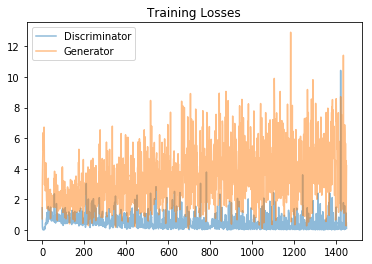

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [29]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

It looks like low quality pictures, I have tried with a small number of epochs and a bigger one, and I noticed that it hasn't improved much, so I think that in order to improve it, I will need to have a deeper model, which will also lead to a longer training time, which is why I haven't done so in this notebook.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.